# Class 4 Hands-on — Decision Trees, Ensembles, Tuning, and Encoding (Exoplanets)

In this notebook we will use **the same exoplanet dataset** as in the previous classes (NASA Exoplanet Archive export, `nea_2026_jan.csv`).

**Goals**
1. Train a **very shallow Decision Tree** and interpret its rules.
2. Compare a single tree to **Random Forest** and  **XGBoost**.
3. Practice **cross-validation** and **hyperparameter tuning**.
4. Compare **categorical encodings** for `discoverymethod`:
   - One-hot encoding (all categories)
   - One-hot encoding with **rare categories grouped** into `Other`
   - **Target encoding with smoothing** (done safely inside CV)

> **Important:** Encoding methods like target encoding can leak information if computed on the full dataset. We will use **pipelines** so the encoding is learned only on training folds.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1) Load the same dataset as previous classes

The previous notebook searched for the CSV in a couple of standard locations.  
Edit `DATA_PATHS` if needed so it matches your repository structure.


In [2]:
DATA_PATHS = [
    Path("../data/nea_2026_jan.csv"),
    Path("nea_2026_jan.csv"),
]

data_path = next((p for p in DATA_PATHS if p.exists()), None)
if data_path is None:
    raise FileNotFoundError(
        "Could not find nea_2026_jan.csv. Tried:\n"
        + "\n".join([str(p) for p in DATA_PATHS])
        + "\n\nEdit DATA_PATHS to match your repository structure."
    )

df = pd.read_csv(data_path)
print(f"Loaded: {data_path} | shape={df.shape}")
df.head()


Loaded: ..\data\nea_2026_jan.csv | shape=(6065, 14)


,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_eqt,st_teff,st_met
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,323.21000,1.178,NaN,4914.898486,NaN,4874.0,-0.26
1,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,516.21997,1.530,NaN,4684.814200,NaN,4213.0,-0.02
2,14 And b,14 And,1,1,1,Radial Velocity,2008,186.76000,0.775,NaN,1131.151301,NaN,4888.0,-0.21
3,14 Her b,14 Her,1,1,2,Radial Velocity,2002,1765.03890,2.774,NaN,2559.472162,NaN,NaN,NaN
4,16 Cyg B b,16 Cyg B,1,3,1,Radial Velocity,1996,798.50000,1.660,NaN,565.737400,NaN,5750.0,0.06


## 2) Define the target (same as Class 3)

We classify planets into:
- **0 = small**: radius < 4 Earth radii
- **1 = large**: radius ≥ 4 Earth radii

We will also prepare a clean feature table including the categorical column:
- `discoverymethod`


In [3]:
# Columns used in Class 3
col_mass = "pl_bmasse"
col_rad  = "pl_rade"
col_teq  = "pl_eqt" 

# Categorical feature we want to study
col_method = "discoverymethod"

# Basic sanity checks
required = [col_mass, col_rad]
missing = [c for c in required if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}")

# Start from a minimal set of features (we'll add more numeric features below if they exist)
base_numeric = [col_mass, col_teq]


# Add a couple of common NEA numeric columns if present (kept optional)
optional_numeric_candidates = [
    "pl_orbper",     # orbital period [days]
    "st_teff",       # stellar Teff
    "st_logg",       # stellar log g
    "st_met",        # stellar metallicity [Fe/H]
]
numeric_cols = base_numeric + [c for c in optional_numeric_candidates if c in df.columns]

# Build a working dataframe
work_cols = numeric_cols + [col_rad]
if col_method in df.columns:
    work_cols.append(col_method)

work = df[work_cols].copy()

# Clean target
R_BOUND = 3.0
work = work[np.isfinite(work[col_rad]) & (work[col_rad] > 0)]

y = (work[col_rad].to_numpy() >= R_BOUND).astype(int)

print("Class fractions (0=small, 1=large):")
print(pd.Series(y).value_counts(normalize=True).sort_index())

work.head()


Class fractions (0=small, 1=large):
0    0.652664
1    0.347336
Name: proportion, dtype: float64


,pl_bmasse,pl_eqt,pl_orbper,st_teff,st_met,pl_rade,discoverymethod
14,4417.8370,NaN,NaN,3064.0,NaN,16.140960,Imaging
36,7.9900,NaN,0.736547,5172.0,0.35,1.875000,Radial Velocity
54,NaN,600.0,8.463080,3678.0,0.23,3.956770,Transit
55,NaN,459.0,18.859690,3678.0,0.23,2.522021,Transit
66,22.2481,NaN,41.685500,5766.0,-0.15,2.578070,Transit


## 3) Quick EDA for `discoverymethod` (category frequency)

- why one-hot encoding can explode dimensionality
- why rare categories can be noisy


discoverymethod
Transit                          4453
Radial Velocity                    31
Imaging                            26
Transit Timing Variations          10
Orbital Brightness Modulation       3
Name: count, dtype: int64

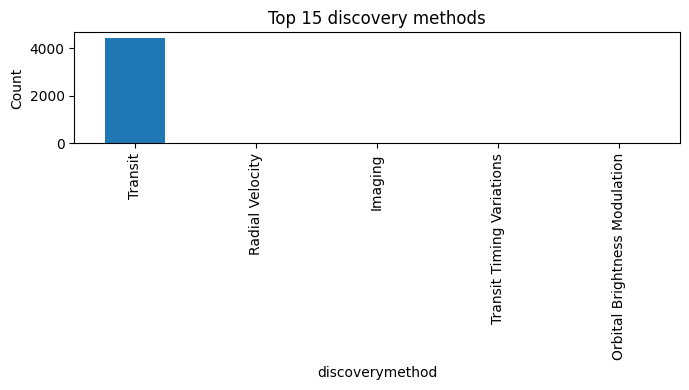

In [4]:
if col_method not in work.columns:
    raise KeyError("Column 'discoverymethod' not found in this dataset export.")

method_counts = work[col_method].fillna("Unknown").value_counts()
display(method_counts.head(15))

plt.figure(figsize=(7,4))
method_counts.head(15).plot(kind="bar")
plt.ylabel("Count")
plt.title("Top 15 discovery methods")
plt.tight_layout()
plt.show()


## 4) Train/test split (for interpretability demos)

We will use a hold-out split for visual demos (tree plot), and **cross-validation** for robust comparisons.


In [5]:
X = work.drop(columns=[col_rad]).copy()
X[col_mass] = np.where(X[col_mass] > 0, X[col_mass], np.nan)

# Often helpful: log-transform mass for smoother splits (optional)
X["log10_pl_bmasse"] = np.log10(X[col_mass])

# Drop raw mass to avoid duplicate information (keep only log mass)
X = X.drop(columns=[col_mass])

# Separate feature lists
cat_cols = [col_method]
num_cols = [c for c in X.columns if c not in cat_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

print("X shape:", X.shape, " | numeric:", num_cols, " | categorical:", cat_cols)


X shape: (4523, 6)  | numeric: ['pl_eqt', 'pl_orbper', 'st_teff', 'st_met', 'log10_pl_bmasse']  | categorical: ['discoverymethod']


## 5) Define three encoding strategies for `discoverymethod`

### A) One-hot (all categories)
### B) One-hot (major categories) + `Other`
### C) Target encoding with smoothing (safe inside CV)

We will implement (B) and (C) as small custom transformers so they can be used inside `Pipeline` and avoid leakage.


In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    """Group rare categories into 'Other' based on top_k most frequent categories."""
    def __init__(self, top_k=5, other_label="Other"):
        self.top_k = top_k
        self.other_label = other_label

    def fit(self, X, y=None):
        # X is expected to be a 2D array or DataFrame with a single categorical column
        s = pd.Series(X.squeeze()).fillna("Unknown")
        self.top_ = s.value_counts().head(self.top_k).index.tolist()
        return self

    def transform(self, X):
        s = pd.Series(X.squeeze()).fillna("Unknown")
        s = s.where(s.isin(self.top_), other=self.other_label)
        return s.to_frame()

class SmoothedTargetEncoder(BaseEstimator, TransformerMixin):
    """Target encode a single categorical column with smoothing.

    Encoding per category c:
        y_hat_c = (n_c * mean_c + alpha * global_mean) / (n_c + alpha)
    """
    def __init__(self, alpha=20.0, handle_unknown="global"):
        self.alpha = float(alpha)
        self.handle_unknown = handle_unknown

    def fit(self, X, y):
        s = pd.Series(X.squeeze()).fillna("Unknown")
        y = pd.Series(y).astype(float)
        self.global_mean_ = y.mean()
        stats = y.groupby(s).agg(["count","mean"])
        n = stats["count"]
        m = stats["mean"]
        self.mapping_ = ((n * m + self.alpha * self.global_mean_) / (n + self.alpha)).to_dict()
        return self

    def transform(self, X):
        s = pd.Series(X.squeeze()).fillna("Unknown")
        out = s.map(self.mapping_)
        if self.handle_unknown == "global":
            out = out.fillna(self.global_mean_)
        else:
            out = out.fillna(0.0)
        return out.to_frame(name="discoverymethod_target_enc")

# Preprocessors for numeric features
num_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

# A) One-hot all
preprocess_onehot_all = ColumnTransformer(
    transformers=[
        ("num", num_preprocess, num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

# B) One-hot major + Other
preprocess_onehot_major = ColumnTransformer(
    transformers=[
        ("num", num_preprocess, num_cols),
        ("cat", Pipeline(steps=[
            ("group_rare", RareCategoryGrouper(top_k=3, other_label="Other")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")), # Ignores unseen categories during transformation. The output for that feature will be all zeros in the encoded vector.
        ]), cat_cols),
    ],
    remainder="drop"
)

# C) Target encoding + smoothing (produces a numeric column)
preprocess_target = ColumnTransformer(
    transformers=[
        ("num", num_preprocess, num_cols),
        ("cat", Pipeline(steps=[
            ("tenc", SmoothedTargetEncoder(alpha=20.0)),
        ]), cat_cols),
    ],
    remainder="drop"
)


## 6) Very shallow Decision Tree (interpretability demo)

We will fit a tree with `max_depth=2` so we can **read it** and interpret the rules.


Test accuracy: 0.7966401414677277
Test ROC AUC : 0.757545667059724


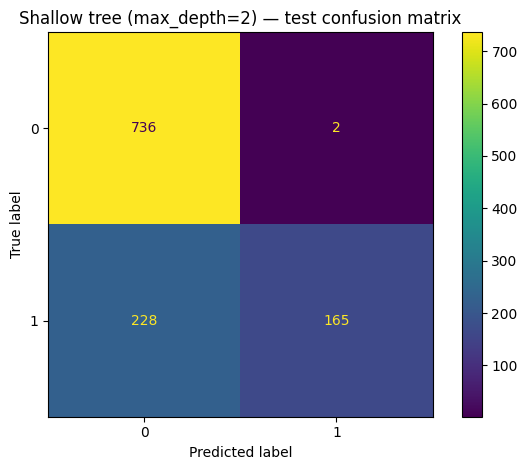

In [7]:
dt_demo = Pipeline(steps=[
    ("prep", preprocess_onehot_major),
    ("clf", DecisionTreeClassifier(max_depth=2, min_samples_leaf=50, random_state=RANDOM_STATE, )) # criterion="entropy",
])

dt_demo.fit(X_train, y_train)
y_pred = dt_demo.predict(X_test)
y_proba = dt_demo.predict_proba(X_test)[:,1]

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test ROC AUC :", roc_auc_score(y_test, y_proba))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Shallow tree (max_depth=2) — test confusion matrix")
plt.tight_layout()
plt.show()


### Plot the tree (rules)

To plot the tree, we need the expanded feature names after preprocessing (one-hot).


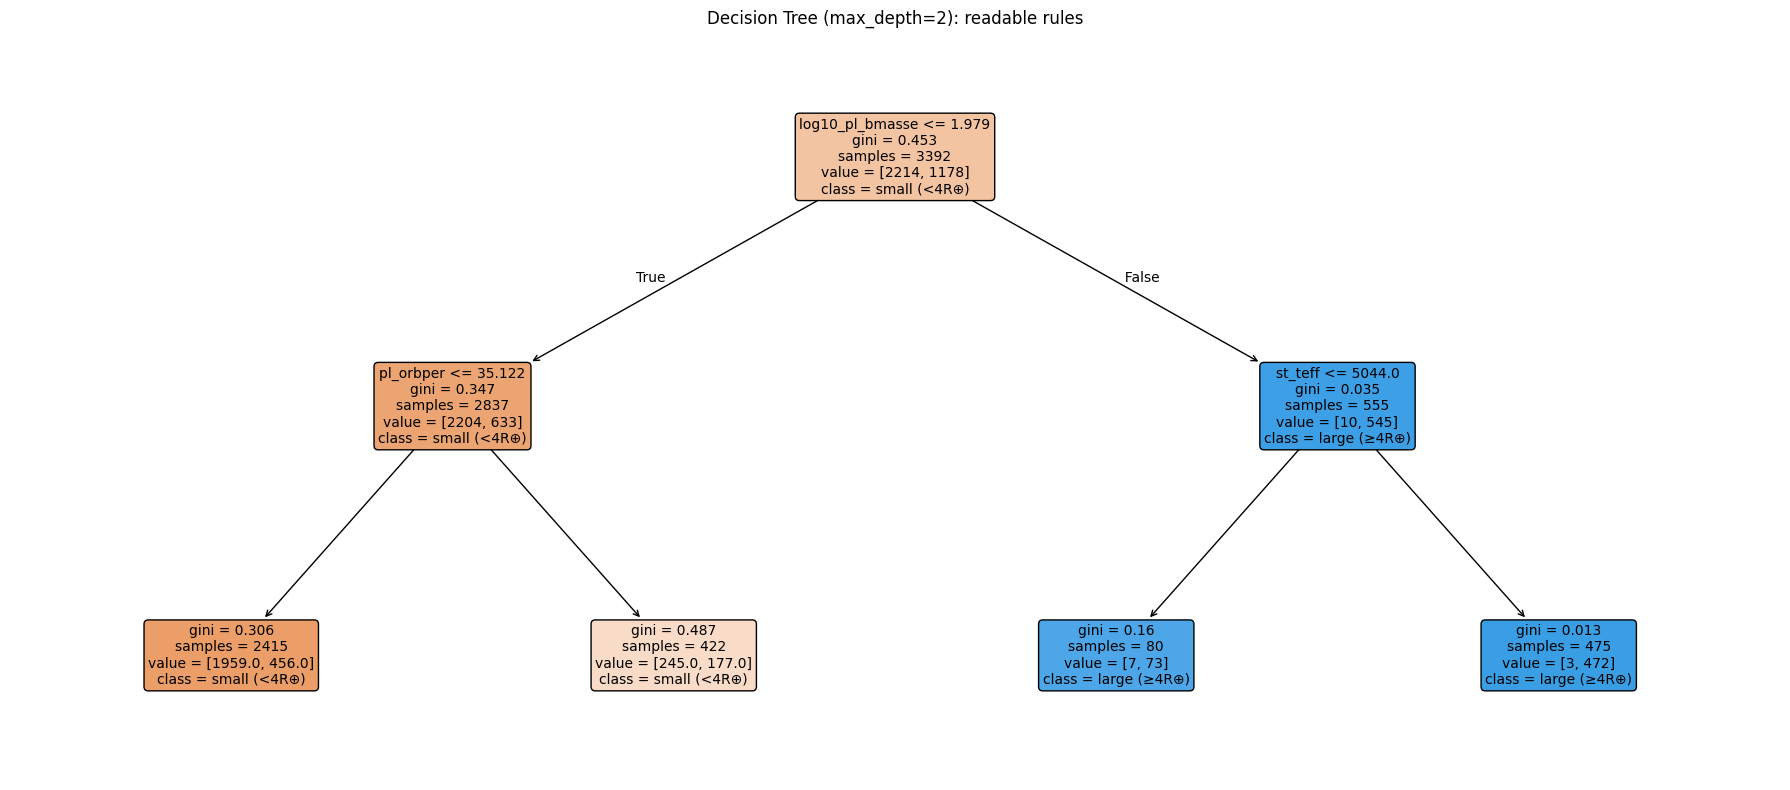

In [8]:
# Extract fitted tree and feature names
tree = dt_demo.named_steps["clf"]   # tree is the trained DecisionTreeClassifier inside the pipeline
prep = dt_demo.named_steps["prep"]  # prep is the preprocessing object/function inside the pipeline

# Get feature names after ColumnTransformer
feature_names = []
# numeric
feature_names.extend(num_cols)
# categorical
ohe = prep.named_transformers_["cat"].named_steps["onehot"]
cats = ohe.get_feature_names_out([col_method])
feature_names.extend(list(cats))

plt.figure(figsize=(18, 8))
plot_tree(
    tree,
    feature_names=feature_names,
    class_names=["small (<4R⊕)", "large (≥4R⊕)"],
    filled=True,
    rounded=True,
    max_depth=2,
    fontsize=10
)
plt.title("Decision Tree (max_depth=2): readable rules")
plt.tight_layout()
plt.show()


## 7) Robust comparison with Cross-Validation (CV)

We now compare **encoding strategies** and **models** using the same CV scheme.


In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def cv_auc(pipeline):
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    return scores.mean(), scores.std()

# Models
dt = DecisionTreeClassifier(max_depth=None, random_state=RANDOM_STATE)
rf = RandomForestClassifier(
    n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1,
    max_features="sqrt"
)

pipelines = {
    "DT + onehot(all)": Pipeline([("prep", preprocess_onehot_all), ("clf", dt)]),
    "DT + onehot(major+Other)": Pipeline([("prep", preprocess_onehot_major), ("clf", dt)]),
    "DT + target(smooth)": Pipeline([("prep", preprocess_target), ("clf", dt)]),

    "RF + onehot(all)": Pipeline([("prep", preprocess_onehot_all), ("clf", rf)]),
    "RF + onehot(major+Other)": Pipeline([("prep", preprocess_onehot_major), ("clf", rf)]),
    "RF + target(smooth)": Pipeline([("prep", preprocess_target), ("clf", rf)]),
}

rows = []
for name, pipe in pipelines.items():
    mu, sd = cv_auc(pipe)
    rows.append({"pipeline": name, "roc_auc_mean": mu, "roc_auc_std": sd})

results = pd.DataFrame(rows).sort_values("roc_auc_mean", ascending=False)
results


,pipeline,roc_auc_mean,roc_auc_std
4,RF + onehot(major+Other),0.861579,0.010843
3,RF + onehot(all),0.861561,0.011953
5,RF + target(smooth),0.861054,0.011204
2,DT + target(smooth),0.746452,0.015873
1,DT + onehot(major+Other),0.744995,0.018779
0,DT + onehot(all),0.743189,0.018814


## Alternative (illustration): One-Hot Encoding + CV step-by-step (no Pipeline)

We will:
- Impute missing numeric values using the median
- One-hot encode `discoverymethod`

The pipeline version is convenient because it *automatically* fits preprocessing **only on the training fold** inside cross-validation.

To make the logic fully transparent, the next cell shows the *same idea* done manually for **one-hot encoding**: for each fold we fit the encoder on the training fold, transform both training and validation folds, then fit the classifier and score it.



In [10]:
def impute_numeric(train_df, test_df, num_cols):
    imp = SimpleImputer(strategy='median')
    Xtr_num = pd.DataFrame(imp.fit_transform(train_df[num_cols]), columns=num_cols, index=train_df.index)
    Xte_num = pd.DataFrame(imp.transform(test_df[num_cols]), columns=num_cols, index=test_df.index)
    return Xtr_num, Xte_num

def one_hot_all(train_df, test_df, col):
    # One-hot using train categories, align columns
    dtr = pd.get_dummies(train_df[col].fillna('Missing'), prefix=col)
    dte = pd.get_dummies(test_df[col].fillna('Missing'), prefix=col)
    dte = dte.reindex(columns=dtr.columns, fill_value=0)
    return dtr, dte

def build_X_onehot_all(train_df, test_df, num_cols, cat_col):
    Xtr_num, Xte_num = impute_numeric(train_df, test_df, num_cols)
    if cat_col is None:
        return Xtr_num, Xte_num
    dtr, dte = one_hot_all(train_df, test_df, cat_col)
    Xtr = pd.concat([Xtr_num, dtr], axis=1)
    Xte = pd.concat([Xte_num, dte], axis=1)
    return Xtr, Xte


cat_col = 'discoverymethod'
num_cols_demo = num_cols  # reuse numeric columns selected earlier

cv_demo = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
auc_scores = []

for fold, (tr_idx, va_idx) in enumerate(cv_demo.split(X, y), 1):
    X_tr, X_va = X.iloc[tr_idx].copy(), X.iloc[va_idx].copy()
    y_tr, y_va = y[tr_idx], y[va_idx]

    # 1) Impute numeric features using TRAIN statistics only
    imp = SimpleImputer(strategy='median')
    Xtr_num = imp.fit_transform(X_tr[num_cols_demo])
    Xva_num = imp.transform(X_va[num_cols_demo])

    # 2) Fit OneHotEncoder on TRAIN categories only
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    Xtr_cat = ohe.fit_transform(X_tr[[cat_col]].fillna('Unknown'))
    Xva_cat = ohe.transform(X_va[[cat_col]].fillna('Unknown'))

    # 3) Combine numeric + categorical matrices
    Xtr_all = np.hstack([Xtr_num, Xtr_cat])
    Xva_all = np.hstack([Xva_num, Xva_cat])

    # 4) Fit classifier and score
    clf = DecisionTreeClassifier(max_depth=4, random_state=RANDOM_STATE)
    clf.fit(Xtr_all, y_tr)
    p_va = clf.predict_proba(Xva_all)[:, 1]
    auc = roc_auc_score(y_va, p_va)
    auc_scores.append(auc)

print(f'Manual OHE+CV AUC: mean={np.mean(auc_scores):.3f}, std={np.std(auc_scores):.3f}')
print('Fold AUCs:', [round(a, 3) for a in auc_scores])


Manual OHE+CV AUC: mean=0.817, std=0.015
Fold AUCs: [0.794, 0.811, 0.815, 0.831, 0.834]


## 8) Hyperparameter tuning with Grid Search (example)

We tune a Random Forest using CV.  
(For speed in class, keep the grid small. In real research, the grid can be larger.)


In [11]:
rf_pipe = Pipeline(steps=[
    ("prep", preprocess_onehot_major),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid = {
    "clf__n_estimators": [200, 500],
    "clf__max_depth": [None, 8, 16],
    "clf__min_samples_leaf": [5, 20],
    "clf__max_features": ["sqrt", 0.5],
}

gs = GridSearchCV(
    rf_pipe, param_grid=param_grid,
    cv=cv, scoring="roc_auc", n_jobs=-1, verbose=1
)
gs.fit(X, y)

print("Best CV ROC AUC:", gs.best_score_)
print("Best params:", gs.best_params_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best CV ROC AUC: 0.8803071060553321
Best params: {'clf__max_depth': 8, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 200}


## 9) Modern tuning with Optuna

If Optuna is available, we can do a smarter search than a grid.

> If Optuna is not installed in your environment, skip this section.


In [12]:
try:
    import optuna
    import optuna.visualization as vis
    from sklearn.model_selection import cross_val_score
    OPTUNA_AVAILABLE = True
except Exception as e:
    OPTUNA_AVAILABLE = False
    print("Optuna not available:", e)

OPTUNA_AVAILABLE


C:\Users\adbva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [13]:
if OPTUNA_AVAILABLE:
    def objective(trial):
        n_estimators = trial.suggest_int("n_estimators", 200, 800)
        max_depth = trial.suggest_categorical("max_depth", [None, 6, 10, 16])
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 30)
        max_features = trial.suggest_categorical("max_features", ["sqrt", 0.5, 0.8])

        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )

        pipe = Pipeline([("prep", preprocess_onehot_major), ("clf", model)])
        scores = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)
    
    print("Best ROC AUC:", study.best_value)
    print("Best params:", study.best_params)


[I 2026-01-18 11:43:02,646] A new study created in memory with name: no-name-f7bc7ed6-7b1e-4659-b3bb-17e57c50f32f
[I 2026-01-18 11:43:04,551] Trial 0 finished with value: 0.8730936652078419 and parameters: {'n_estimators': 581, 'max_depth': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8730936652078419.
[I 2026-01-18 11:43:08,316] Trial 1 finished with value: 0.87887679413775 and parameters: {'n_estimators': 791, 'max_depth': 6, 'min_samples_leaf': 10, 'max_features': 0.8}. Best is trial 1 with value: 0.87887679413775.
[I 2026-01-18 11:43:10,856] Trial 2 finished with value: 0.8759748654466003 and parameters: {'n_estimators': 602, 'max_depth': None, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.87887679413775.
[I 2026-01-18 11:43:13,947] Trial 3 finished with value: 0.8755139175491738 and parameters: {'n_estimators': 779, 'max_depth': 16, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8788

Best ROC AUC: 0.8792673238010392
Best params: {'n_estimators': 610, 'max_depth': 10, 'min_samples_leaf': 9, 'max_features': 0.8}


In [14]:
vis.plot_optimization_history(study)

In [15]:
vis.plot_param_importances(study)

In [16]:
vis.plot_contour(study, params=["max_depth", "min_samples_leaf"])


## 10) XGBoost

If `xgboost` is available, you can compare boosting to bagging.


In [17]:
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception as e:
    XGB_AVAILABLE = False
    print("xgboost not available:", e)

XGB_AVAILABLE


True

In [18]:
if XGB_AVAILABLE:
    xgb = XGBClassifier(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric="logloss"
    )
    xgb_pipe = Pipeline([("prep", preprocess_onehot_major), ("clf", xgb)])
    scores = cross_val_score(xgb_pipe, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    print("XGBoost CV ROC AUC:", scores.mean(), "+/-", scores.std())


XGBoost CV ROC AUC: 0.8757622341806688 +/- 0.011333231740396325


In [19]:
# --- Optuna + XGBoost tuning (similar to the RF example) ---
if OPTUNA_AVAILABLE:
    try:
        from xgboost import XGBClassifier
        XGBOOST_AVAILABLE = True
    except Exception as e:
        XGBOOST_AVAILABLE = False
        print("XGBoost not available:", e)

    if XGBOOST_AVAILABLE:
        def objective_xgb(trial):
            # Core booster hyperparameters
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 200, 800),
                "max_depth": trial.suggest_int("max_depth", 2, 10),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),

                # Stochasticity (often improves generalization)
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),

                # Regularization / split control
                "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 30.0, log=True),
                "gamma": trial.suggest_float("gamma", 0.0, 5.0),
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
                "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
            }

            model = XGBClassifier(
                **params,
                objective="binary:logistic",
                eval_metric="logloss",         # avoids warnings; we score with roc_auc via CV
                tree_method="hist",            # fast on CPU
                random_state=RANDOM_STATE,
                n_jobs=-1
            )

            pipe = Pipeline([("prep", preprocess_onehot_major), ("clf", model)])
            scores = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
            return scores.mean()

        study_xgb = optuna.create_study(direction="maximize")
        study_xgb.optimize(objective_xgb, n_trials=10)

        print("Best ROC AUC:", study_xgb.best_value)
        print("Best params:", study_xgb.best_params)


[I 2026-01-18 11:43:31,260] A new study created in memory with name: no-name-4a27d347-044a-422f-8160-aebd47e1179f
[I 2026-01-18 11:43:31,463] Trial 0 finished with value: 0.8738843715347848 and parameters: {'n_estimators': 241, 'max_depth': 2, 'learning_rate': 0.018203964381547602, 'subsample': 0.6446317826206147, 'colsample_bytree': 0.784767712400988, 'min_child_weight': 14.393455504726477, 'gamma': 3.440205919397192, 'reg_alpha': 0.021284532885658066, 'reg_lambda': 0.0098489825940804}. Best is trial 0 with value: 0.8738843715347848.
[I 2026-01-18 11:43:31,912] Trial 1 finished with value: 0.8822974266010745 and parameters: {'n_estimators': 569, 'max_depth': 6, 'learning_rate': 0.010039071180405736, 'subsample': 0.7682861956355002, 'colsample_bytree': 0.6450692961396338, 'min_child_weight': 7.305762310396121, 'gamma': 3.794382295976516, 'reg_alpha': 1.6492353007916756e-05, 'reg_lambda': 2.9667349231280432e-05}. Best is trial 1 with value: 0.8822974266010745.
[I 2026-01-18 11:43:32,281

Best ROC AUC: 0.8822974266010745
Best params: {'n_estimators': 569, 'max_depth': 6, 'learning_rate': 0.010039071180405736, 'subsample': 0.7682861956355002, 'colsample_bytree': 0.6450692961396338, 'min_child_weight': 7.305762310396121, 'gamma': 3.794382295976516, 'reg_alpha': 1.6492353007916756e-05, 'reg_lambda': 2.9667349231280432e-05}


In [20]:
vis.plot_optimization_history(study_xgb)

In [21]:
vis.plot_param_importances(study_xgb)